In [1]:
!git clone https://github.com/lkeab/BCNet.git

Cloning into 'BCNet'...
remote: Enumerating objects: 1349, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 1349 (delta 84), reused 76 (delta 76), pack-reused 1260 (from 1)
Receiving objects: 100% (1349/1349), 6.65 MiB | 10.59 MiB/s, done.
Resolving deltas: 100% (593/593), done.


In [3]:
!python -m pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [5]:
!pip install numpy termcolor tqdm pillow yacs tabulate cloudpickle fvcore matplotlib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'fvcore' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'fvcore'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=cd439df908b89b9871f8867ecd9e8a4a15cce20b1c94ac95c26e82aef4cf8c60
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  DEPRECATION: Building 'iopath' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement

In [6]:
!pip install pycocotools

In [7]:
import os
import json
from pycocotools.coco import COCO
import requests
from PIL import Image
from io import BytesIO

output_dir = "/content/output"
data_dir = os.path.join(output_dir, "coco_subset")
image_dir = os.path.join(data_dir, "images")
ann_dir = os.path.join(data_dir, "annotations")
os.makedirs(image_dir, exist_ok=True)
os.makedirs(ann_dir, exist_ok=True)

# Download COCO 2017 val annotations
ann_file_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
ann_zip_path = os.path.join(output_dir, "annotations_trainval2017.zip")

# Download the zip
if not os.path.exists(ann_zip_path):
    print("Downloading COCO annotations...")
    !wget -q -O "$ann_zip_path" "$ann_file_url"

# Extract only instances_val2017.json from the zip
ann_json_path = os.path.join(ann_dir, "instances_val2017.json")
if not os.path.exists(ann_json_path):
    print("Extracting instances_val2017.json...")
    !unzip -o -j "$ann_zip_path" "annotations/instances_val2017.json" -d "$ann_dir"

Extracting instances_val2017.json...
Archive:  /content/output/annotations_trainval2017.zip
  inflating: /content/output/coco_subset/annotations/instances_val2017.json  


In [8]:
# Load COCO annotations
ann_json_path = os.path.join(ann_dir, "instances_val2017.json")
coco = COCO(ann_json_path)

# Select a small subset of images for training and testing.
# We will filter for images that have overlapping instances (occlusions) to demonstrate BCNet.
image_ids = []
for img_id in coco.getImgIds():
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    # Check if any two annotations in this image overlap in terms of bounding box
    overlaps = False
    for i in range(len(anns)):
        for j in range(i+1, len(anns)):
            # Compute bounding box overlap
            x1 = max(anns[i]['bbox'][0], anns[j]['bbox'][0])
            y1 = max(anns[i]['bbox'][1], anns[j]['bbox'][1])
            x2 = min(anns[i]['bbox'][0] + anns[i]['bbox'][2], anns[j]['bbox'][0] + anns[j]['bbox'][2])
            y2 = min(anns[i]['bbox'][1] + anns[i]['bbox'][3], anns[j]['bbox'][1] + anns[j]['bbox'][3])
            if x2 > x1 and y2 > y1:
                overlaps = True
                break
        if overlaps:
            break
    if overlaps:
        image_ids.append(img_id)
    if len(image_ids) >= 25:  # take 25 images with overlaps
        break

print(f"Selected {len(image_ids)} images with overlapping instances for the subset.")

# Load image metadata for selected IDs
images_info = coco.loadImgs(image_ids)

# Download the selected images to the output directory
for img_info in images_info:
    file_name = img_info['file_name']
    url = img_info['coco_url']
    save_path = os.path.join(image_dir, file_name)
    if not os.path.exists(save_path):
        # Download image from COCO server
        resp = requests.get(url)
        Image.open(BytesIO(resp.content)).save(save_path)
print("Downloaded subset of images to", image_dir)

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
Selected 25 images with overlapping instances for the subset.
Downloaded subset of images to /content/output/coco_subset/images


In [9]:
# Create a subset annotation JSON for the selected images (for record-keeping or potential use)
subset_ann_path = os.path.join(ann_dir, "instances_val2017_subset.json")
subset_images = []
subset_annotations = []
image_id_set = set(image_ids)
for img in coco.dataset['images']:
    if img['id'] in image_id_set:
        subset_images.append(img)
        # Collect annotations for this image
        ann_ids = coco.getAnnIds(imgIds=img['id'])
        anns = coco.loadAnns(ann_ids)
        # Only include annotations that belong to the selected image
        for ann in anns:
            if ann['image_id'] in image_id_set:
                subset_annotations.append(ann)
# Keep the category information unchanged
categories = coco.dataset['categories']

# Write out the subset annotation file
subset_data = {
    "images": subset_images,
    "annotations": subset_annotations,
    "categories": categories
}
with open(subset_ann_path, 'w') as f:
    json.dump(subset_data, f)
print("Saved subset annotations to", subset_ann_path)

# For convenience, load all selected images into memory and prepare ground truth masks for occluder/occludee
from pycocotools import mask as maskUtils
import numpy as np

# Define mask output resolution (e.g., 28x28 as used in Mask R-CNN)
MASK_SIZE = 28

# Data structures for training and testing
train_split = 20  # use first 20 images for training, rest for testing
train_ids = image_ids[:train_split]
test_ids = image_ids[train_split:]

# Dictionary to store loaded images (as PIL or numpy arrays) for quick access
images = {}
for img_info in images_info:
    img_id = img_info['id']
    if img_id in image_id_set:
        # Load image from file
        img_path = os.path.join(image_dir, img_info['file_name'])
        images[img_id] = Image.open(img_path).convert("RGB")

# Prepare list of training samples (ROIs) and testing samples
train_samples = []
test_samples = []

for img_id in image_id_set:
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    # For each object in the image, treat it as the target (occludee)
    for ann in anns:
        target_mask_full = coco.annToMask(ann)  # full-size binary mask of target object
        # Determine occluder mask as union of other objects overlapping this target
        occluder_mask_full = np.zeros_like(target_mask_full, dtype=np.uint8)
        for other_ann in anns:
            if other_ann['id'] == ann['id']:
                continue
            # Only consider other objects that actually overlap the target's bounding box
            x,y,w,h = ann['bbox']
            other_x, other_y, other_w, other_h = other_ann['bbox']
            # Check if bounding boxes intersect
            if not (other_x > x+w or other_x+other_w < x or other_y > y+h or other_y+other_h < y):
                # Add other object's mask into occluder mask
                occluder_mask_full = np.maximum(occluder_mask_full, coco.annToMask(other_ann))
        # Crop the ROI region from the masks
        x, y, w, h = ann['bbox']
        # Use int bounds for cropping (expand to ensure coverage of mask)
        x1, y1 = int(np.floor(x)), int(np.floor(y))
        x2, y2 = int(np.ceil(x + w)), int(np.ceil(y + h))
        target_crop = target_mask_full[y1:y2, x1:x2]
        occluder_crop = occluder_mask_full[y1:y2, x1:x2]
        # Resize the cropped masks to MASK_SIZE x MASK_SIZE
        target_mask_resized = Image.fromarray(target_crop.astype(np.uint8)*255).resize((MASK_SIZE, MASK_SIZE), Image.NEAREST)
        occluder_mask_resized = Image.fromarray(occluder_crop.astype(np.uint8)*255).resize((MASK_SIZE, MASK_SIZE), Image.NEAREST)
        target_mask_resized = np.array(target_mask_resized).astype(np.float32) / 255.0  # convert to 0/1 float
        occluder_mask_resized = np.array(occluder_mask_resized).astype(np.float32) / 255.0
        # Package the sample
        sample = {
            "image_id": img_id,
            "roi": (x1, y1, x2, y2),  # ROI coordinates in original image
            "occludee_mask": target_mask_resized,
            "occluder_mask": occluder_mask_resized
        }
        # Split into train or test list
        if img_id in train_ids:
            train_samples.append(sample)
        else:
            test_samples.append(sample)

print(f"Prepared {len(train_samples)} training ROI samples and {len(test_samples)} testing ROI samples.")

Saved subset annotations to /content/output/coco_subset/annotations/instances_val2017_subset.json
Prepared 255 training ROI samples and 24 testing ROI samples.


In [12]:
# Prepare a backbone for feature extraction (ResNet50 up to a certain layer, e.g., layer3 for 1/16 scale features).
import torch
import torch.nn as nn
import torchvision

# CPU 또는 GPU 중 사용 가능한 디바이스를 선택
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Load a pretrained ResNet50 model and use it as a fixed feature extractor
backbone = torchvision.models.resnet50(pretrained=True)
backbone.eval()  # set to eval mode (we will not train the backbone)
# We will use layers up to layer3 of ResNet (C4 would be layer4, but we'll use layer3 to keep higher resolution features)
# Construct a new nn.Sequential for the feature extractor
layers = []
layers.append(nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool))  # down to 1/4 resolution
layers.append(backbone.layer1)  # 1/4 resolution
layers.append(backbone.layer2)  # 1/8 resolution
layers.append(backbone.layer3)  # 1/16 resolution
feature_extractor = nn.Sequential(*layers).to(device)
# Freeze backbone parameters
for param in feature_extractor.parameters():
    param.requires_grad = False

# The output of layer3 has 256 * 4 (bottleneck expands to 1024 channels for ResNet50 layer3).
# Actually, ResNet50 layer3 (which is layer3 in torchvision) outputs 1024 channels.
# But our mask head expects 256 channels in input. We will adjust by adding a 1x1 conv if needed.
# For simplicity, let's add a 1x1 conv to reduce backbone output channels to 256.
backbone_out_channels = 1024  # ResNet50 layer3 output channels
reduce_conv = nn.Conv2d(backbone_out_channels, 256, kernel_size=1).to(device)
reduce_conv.weight.data.normal_(0, 0.01)
reduce_conv.bias.data.zero_()
reduce_conv.requires_grad_(False)  # keep it fixed as well for now (or we could train this tiny layer if desired)

# Test the feature extractor on a dummy input to verify shapes (optional)
dummy = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    feat = feature_extractor(dummy)
    feat = reduce_conv(feat)
print("Backbone feature map shape:", feat.shape)

Using device: cuda
Backbone feature map shape: torch.Size([1, 256, 14, 14])


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set device for computation (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define a Graph Convolution (GCN) block for one layer (occluder or occludee)
class GraphConvBlock(nn.Module):
    def __init__(self, in_channels):
        """
        GraphConvBlock implements a non-local Graph Convolutional layer as described in BCNet.
        It uses learnable transformations theta, phi to compute an adjacency matrix based on feature similarity,
        and a learnable weight Wg for feature transformation. A residual connection and LayerNorm+ReLU are applied.
        """
        super(GraphConvBlock, self).__init__()
        self.theta = nn.Conv2d(in_channels, in_channels, kernel_size=1)  # theta transformation
        self.phi   = nn.Conv2d(in_channels, in_channels, kernel_size=1)  # phi transformation
        self.g     = nn.Conv2d(in_channels, in_channels, kernel_size=1)  # Wg transformation for features
        # LayerNorm will be applied over the channel dimension for each spatial node (pixel)
        self.norm  = nn.LayerNorm(in_channels)
    def forward(self, x):
        """
        Forward pass of GraphConvBlock.
        Input: x of shape (N, C, H, W) - N=batch of ROIs (we will typically use N=1 for a single ROI).
        Output: out of the same shape (N, C, H, W) after graph convolution and residual.
        """
        N, C, H, W = x.shape
        # Compute theta and phi feature maps
        theta_x = self.theta(x)   # shape: [N, C, H, W]
        phi_x   = self.phi(x)     # shape: [N, C, H, W]
        # Reshape to (N, C, M) where M = H*W (each spatial location as a node)
        M = H * W
        theta_x = theta_x.view(N, C, M)  # [N, C, M]
        phi_x   = phi_x.view(N, C, M)    # [N, C, M]
        # Compute attention (adjacency) matrix A of shape [N, M, M]
        # We compute A_ij = softmax_i(theta_x^T * phi_x)_ij (similarity between node i and j)
        # First compute similarity: theta_x^T (C x M) * phi_x (C x M) for each N
        # We will compute for each batch separately
        A = torch.zeros((N, M, M), device=x.device)
        for b in range(N):
            # similarity matrix for batch b: (M x C) * (C x M) = (M x M)
            sim_matrix = torch.mm(theta_x[b].T, phi_x[b])  # [M, M]
            # apply softmax on each row
            A[b] = F.softmax(sim_matrix, dim=1)
        # Compute transformed features via Wg (g)
        g_x = self.g(x)  # [N, C, H, W]
        g_x = g_x.view(N, C, M)  # [N, C, M]
        # Perform graph convolution: Z = A * g_x^T, where g_x^T is [M, C]
        # Actually, we want output shape [N, C, M]: do matrix multiply A (M x M) * g_x^T (M x C) = (M x C), then transpose -> (C x M)
        out = torch.zeros((N, C, M), device=x.device)
        for b in range(N):
            out_b = torch.mm(A[b], g_x[b].T).T  # (M x M) * (M x C) = (M x C), then transpose to (C x M)
            out[b] = out_b
        # Reshape out to (N, C, H, W)
        out = out.view(N, C, H, W)
        # Apply LayerNorm and ReLU (per spatial location, normalize over C)
        # We need to permute to (N, H, W, C) for LayerNorm over channels, then back
        out = out.permute(0, 2, 3, 1)  # (N, H, W, C)
        out = self.norm(out)          # LayerNorm on channel dimension C
        out = F.relu(out)
        out = out.permute(0, 3, 1, 2)  # back to (N, C, H, W)
        # Add residual connection (original input x)
        out = out + x
        return out

# Define the BCNet mask head module
class BCNetMaskHead(nn.Module):
    def __init__(self, in_channels, feature_channels=256):
        """
        BCNetMaskHead implements the bilayer GCN mask prediction head.
        It takes ROI feature maps and produces two mask outputs: occluder mask and occludee mask.
        in_channels: number of channels of the ROI feature input.
        feature_channels: internal feature dimension (default 256 as in Mask R-CNN heads).
        """
        super(BCNetMaskHead, self).__init__()
        # Occluder branch layers
        self.conv_occ1 = nn.Conv2d(in_channels, feature_channels, kernel_size=3, padding=1)
        self.gcn_occ = GraphConvBlock(feature_channels)
        self.conv_occ2 = nn.Conv2d(feature_channels, feature_channels, kernel_size=3, padding=1)
        # Occluder mask prediction head (1x1 conv)
        self.conv_occ_mask = nn.Conv2d(feature_channels, 1, kernel_size=1)
        # (We skip explicit occluder boundary head for simplicity)
        # Merge occluder features into occludee branch
        self.merge_conv = nn.Conv2d(feature_channels, feature_channels, kernel_size=1)
        # Occludee branch layers
        self.conv_occdee1 = nn.Conv2d(in_channels, feature_channels, kernel_size=3, padding=1)
        self.gcn_occdee = GraphConvBlock(feature_channels)
        self.conv_occdee2 = nn.Conv2d(feature_channels, feature_channels, kernel_size=3, padding=1)
        # Occludee mask prediction head
        self.conv_occdee_mask = nn.Conv2d(feature_channels, 1, kernel_size=1)
        # Upsampling layer (we will use bilinear upsampling in forward)
        # (Alternatively, one could use ConvTranspose2d for learned upsampling)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, roi_feat):
        """
        Forward pass for BCNetMaskHead.
        roi_feat: input feature map for a single ROI (N, C, H, W).
                  N can be >1 if processing multiple ROIs at once, but we'll typically use N=1.
        Returns: occluder_mask_logits, occludee_mask_logits (each of shape [N, 1, MASK_SIZE, MASK_SIZE])
        """
        N, C, H, W = roi_feat.shape
        # Occluder branch forward
        x_occ = F.relu(self.conv_occ1(roi_feat))        # initial 3x3 conv + ReLU
        x_occ = self.gcn_occ(x_occ)                     # Graph conv for occluder
        x_occ = F.relu(self.conv_occ2(x_occ))           # second 3x3 conv + ReLU
        occ_feat = x_occ  # occluder feature map (N, feature_channels, H, W)
        # Occluder mask output
        occ_up = self.up(occ_feat)                      # upsample to double spatial size (e.g., 14x14 -> 28x28)
        occ_mask_logits = self.conv_occ_mask(occ_up)    # 1x1 conv to produce occluder mask logits (N,1,28,28)
        # Occludee branch forward
        # Combine occluder info with original ROI feature for occludee
        fusion_feat = roi_feat + self.merge_conv(occ_feat)   # add occluder features (transformed by 1x1 conv) to original ROI features
        x_occdee = F.relu(self.conv_occdee1(fusion_feat))    # occludee 3x3 conv + ReLU
        x_occdee = self.gcn_occdee(x_occdee)                 # Graph conv for occludee
        x_occdee = F.relu(self.conv_occdee2(x_occdee))       # second 3x3 conv + ReLU
        occdee_feat = x_occdee
        # Occludee mask output
        occdee_up = self.up(occdee_feat)                     # upsample to 28x28
        occdee_mask_logits = self.conv_occdee_mask(occdee_up) # 1x1 conv for occludee mask logits
        return occ_mask_logits, occdee_mask_logits

# Instantiate the mask head model.
# We'll integrate a backbone (ResNet) for feature extraction below.
mask_head = BCNetMaskHead(in_channels=256, feature_channels=256).to(device)

Using device: cuda


In [15]:
# Training parameters
num_epochs = 50
batch_size = 1  # process one ROI at a time for simplicity
learning_rate = 0.001

# Use Binary Cross Entropy loss with logits for mask predictions
criterion = nn.BCEWithLogitsLoss()
# Optimize only the mask head parameters (since backbone is frozen)
optimizer = torch.optim.Adam(mask_head.parameters(), lr=learning_rate)

mask_head.train()  # set mask head to training mode
for epoch in range(num_epochs):
    total_loss = 0.0
    for sample in train_samples:
        img_id = sample["image_id"]
        # Prepare input ROI features using the backbone
        # Load image and crop ROI
        img = images[img_id]
        roi = sample["roi"]
        x1, y1, x2, y2 = map(int, roi)
        img_crop = img.crop((x1, y1, x2, y2))
        # Convert to tensor
        img_tensor = torchvision.transforms.functional.to_tensor(img_crop).unsqueeze(0).to(device)
        # We can use the backbone on the whole image and then ROIAlign to get features.
        # For simplicity, let's feed the cropped patch directly through the feature extractor.
        with torch.no_grad():
            feat_map = feature_extractor(img_tensor)           # get feature map for the cropped region
            feat_map = reduce_conv(feat_map)                   # reduce channels to 256
        # Now we need a fixed-size ROI feature (e.g., 14x14) for the mask head.
        # We can adapt by using adaptive pooling if needed, but ideally we'd ROIAlign from full image features.
        # Here, since we passed the cropped patch, we will simply resize the feature map to a fixed spatial size (14x14).
        feat_map_resized = F.adaptive_max_pool2d(feat_map, output_size=(14, 14))
        # Forward pass through mask head
        occ_logits, occdee_logits = mask_head(feat_map_resized)
        # Prepare ground truth masks (already 28x28) from sample
        occ_mask_gt = torch.from_numpy(sample["occluder_mask"]).float().to(device)  # shape (28,28)
        occdee_mask_gt = torch.from_numpy(sample["occludee_mask"]).float().to(device)  # shape (28,28)
        # Reshape targets to match output shape [1, 1, 28, 28]
        occ_mask_gt = occ_mask_gt.unsqueeze(0).unsqueeze(0)
        occdee_mask_gt = occdee_mask_gt.unsqueeze(0).unsqueeze(0)
        # Compute losses for occluder and occludee mask
        loss_occ = criterion(occ_logits, occ_mask_gt)
        loss_occdee = criterion(occdee_logits, occdee_mask_gt)
        loss = loss_occ + loss_occdee
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_samples)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
# Save the trained mask head model
os.makedirs(os.path.join(output_dir, "models"), exist_ok=True)
model_path = os.path.join(output_dir, "models", "bcnet_mask_head.pth")
torch.save(mask_head.state_dict(), model_path)
print("Model saved to", model_path)

Epoch 1/50, Average Loss: 1.2079
Epoch 2/50, Average Loss: 1.2189
Epoch 3/50, Average Loss: 1.1762
Epoch 4/50, Average Loss: 1.1825
Epoch 5/50, Average Loss: 1.1544
Epoch 6/50, Average Loss: 1.1508
Epoch 7/50, Average Loss: 1.1140
Epoch 8/50, Average Loss: 1.1100
Epoch 9/50, Average Loss: 1.1030
Epoch 10/50, Average Loss: 1.0730
Epoch 11/50, Average Loss: 1.0674
Epoch 12/50, Average Loss: 1.0370
Epoch 13/50, Average Loss: 1.0282
Epoch 14/50, Average Loss: 1.0070
Epoch 15/50, Average Loss: 0.9955
Epoch 16/50, Average Loss: 0.9891
Epoch 17/50, Average Loss: 0.9852
Epoch 18/50, Average Loss: 1.0119
Epoch 19/50, Average Loss: 0.9864
Epoch 20/50, Average Loss: 0.9617
Epoch 21/50, Average Loss: 0.9382
Epoch 22/50, Average Loss: 0.9304
Epoch 23/50, Average Loss: 0.9029
Epoch 24/50, Average Loss: 0.8917
Epoch 25/50, Average Loss: 0.8733
Epoch 26/50, Average Loss: 0.8596
Epoch 27/50, Average Loss: 0.8443
Epoch 28/50, Average Loss: 0.8497
Epoch 29/50, Average Loss: 0.8246
Epoch 30/50, Average Lo

In [16]:
mask_head.eval()  # set model to evaluation mode

# Function to compute IoU between predicted mask and ground-truth mask
def compute_iou(pred_mask, true_mask):
    # pred_mask and true_mask are binary numpy arrays (0/1)
    inter = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    if union == 0:
        return 0.0
    return inter / union

ious_occludee = []
ious_occluder = []
for sample in test_samples:
    img_id = sample["image_id"]
    roi = sample["roi"]
    # Prepare feature as in training
    img = images[img_id]
    x1, y1, x2, y2 = map(int, roi)
    img_crop = img.crop((x1, y1, x2, y2))
    img_tensor = torchvision.transforms.functional.to_tensor(img_crop).unsqueeze(0).to(device)
    with torch.no_grad():
        feat_map = feature_extractor(img_tensor)
        feat_map = reduce_conv(feat_map)
        feat_map_resized = F.adaptive_max_pool2d(feat_map, output_size=(14, 14))
        occ_logits, occdee_logits = mask_head(feat_map_resized)
        # Apply sigmoid to get probability maps
        occ_prob = torch.sigmoid(occ_logits)
        occdee_prob = torch.sigmoid(occdee_logits)
    # Obtain binary masks (threshold at 0.5)
    occ_mask_pred = (occ_prob.cpu().numpy() >= 0.5).astype(np.uint8).squeeze()
    occdee_mask_pred = (occdee_prob.cpu().numpy() >= 0.5).astype(np.uint8).squeeze()
    # True masks (we have them in the sample dict as numpy arrays 0/1 of shape 28x28)
    occ_mask_true = (sample["occluder_mask"] >= 0.5).astype(np.uint8)
    occdee_mask_true = (sample["occludee_mask"] >= 0.5).astype(np.uint8)
    # Compute IoUs
    iou_occ = compute_iou(occ_mask_pred, occ_mask_true)
    iou_occdee = compute_iou(occdee_mask_pred, occdee_mask_true)
    ious_occluder.append(iou_occ)
    ious_occludee.append(iou_occdee)

# Calculate average IoU for occluder and occludee masks on the test set
avg_iou_occ = np.mean(ious_occluder) if ious_occluder else 0.0
avg_iou_occdee = np.mean(ious_occludee) if ious_occludee else 0.0
print(f"Average IoU on test set - Occluder mask: {avg_iou_occ:.3f}, Occludee mask: {avg_iou_occdee:.3f}")

Average IoU on test set - Occluder mask: 0.142, Occludee mask: 0.524


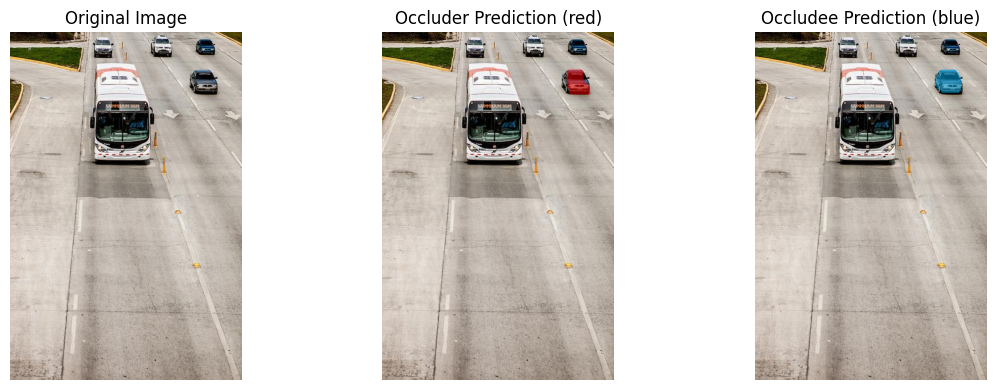

Saved visualization to /content/output/results/result_image_460347.png


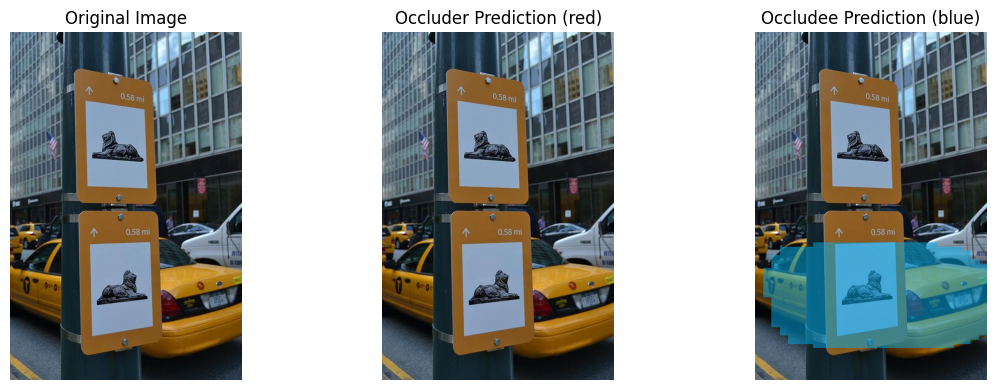

Saved visualization to /content/output/results/result_image_322864.png


In [21]:
import matplotlib.pyplot as plt

# Choose a few test images to visualize results
vis_image_ids = test_ids[:2]  # take first two test images for visualization (if available)
os.makedirs(os.path.join(output_dir, "results"), exist_ok=True)

for img_id in vis_image_ids:
    img = images[img_id]
    # Find one target in this image to visualize (preferably one with an occluder if exists)
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    target_ann = None
    for ann in anns:
        # If this annotation has any occluder (we can check if occluder mask in our data is non-empty)
        for sample in test_samples:
            if sample["image_id"] == img_id and np.sum(sample["occluder_mask"]) > 0:
                target_ann = ann
                break
        if target_ann is not None:
            break
    if target_ann is None:
        target_ann = anns[0]  # fall back to first annotation if none has occluder

    # Use the found target annotation
    x, y, w, h = target_ann['bbox']
    x1, y1 = int(np.floor(x)), int(np.floor(y))
    x2, y2 = int(np.ceil(x + w)), int(np.ceil(y + h))
    roi = (x1, y1, x2, y2)
    # Prepare input and get model predictions
    img_crop = img.crop(roi)
    img_tensor = torchvision.transforms.functional.to_tensor(img_crop).unsqueeze(0).to(device)
    with torch.no_grad():
        feat_map = feature_extractor(img_tensor)
        feat_map = reduce_conv(feat_map)
        feat_map_resized = F.adaptive_max_pool2d(feat_map, output_size=(14, 14))
        occ_logits, occdee_logits = mask_head(feat_map_resized)
        occ_mask = (torch.sigmoid(occ_logits).cpu().numpy() >= 0.5).astype(np.uint8).squeeze()
        occdee_mask = (torch.sigmoid(occdee_logits).cpu().numpy() >= 0.5).astype(np.uint8).squeeze()
    # Resize predicted masks back to the ROI size in the original image
    occ_mask_img = Image.fromarray(occ_mask*255).resize((x2-x1, y2-y1), Image.NEAREST)
    occdee_mask_img = Image.fromarray(occdee_mask*255).resize((x2-x1, y2-y1), Image.NEAREST)
    occ_mask_img = np.array(occ_mask_img) // 255  # 0/1
    occdee_mask_img = np.array(occdee_mask_img) // 255  # 0/1
    # Create color overlays
    img_np = np.array(img)
    overlay_occ = img_np.copy()
    overlay_occdee = img_np.copy()
    # Color occluder region in red
    color_red = np.array([255, 0, 0], dtype=np.uint8)
    # Color occludee region in green (for visibility, or blue)
    color_blue = np.array([0, 176, 240], dtype=np.uint8)  # a bluish color
    # Apply color where mask is 1
    # We use a 50% transparency: average original and color in mask area
    overlay_occ[y1:y2, x1:x2][occ_mask_img == 1] = (0.5 * overlay_occ[y1:y2, x1:x2][occ_mask_img == 1] + 0.5 * color_red).astype(np.uint8)
    overlay_occdee[y1:y2, x1:x2][occdee_mask_img == 1] = (0.5 * overlay_occdee[y1:y2, x1:x2][occdee_mask_img == 1] + 0.5 * color_blue).astype(np.uint8)
    # Plot the original and overlays
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    axes[0].imshow(img_np)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(overlay_occ)
    axes[1].set_title("Occluder Prediction (red)")
    axes[1].axis('off')
    axes[2].imshow(overlay_occdee)
    axes[2].set_title("Occludee Prediction (blue)")
    axes[2].axis('off')
    plt.tight_layout()
    # Save the visualization
    result_path = os.path.join(output_dir, "results", f"result_image_{img_id}.png")
    plt.savefig(result_path)
    plt.show()
    print("Saved visualization to", result_path)